In [1]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL
from langchain_experimental.tools import PythonREPLTool

In [3]:
tavily_tool = TavilySearchResults(max_results=5)

python_repl_tool = PythonREPLTool()

In [4]:
from langchain_core.messages import HumanMessage

In [5]:
from langchain_groq import ChatGroq

In [6]:
llm=ChatGroq(model="llama3-70b-8192")

In [7]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel
from typing import Literal

In [9]:
members = ["Researcher", "Coder"]

In [10]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

In [11]:
options = ["FINISH"] + members

In [12]:
options

['FINISH', 'Researcher', 'Coder']

In [13]:
options=tuple(options)

In [14]:
class routeResponse(BaseModel):
    next: Literal['FINISH', 'Researcher', 'Coder']

In [15]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

In [16]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002892A040910>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002892A0415D0>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [17]:
def supervisor_agent(state):
    supervisor_chain = (
        prompt | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

In [18]:
import functools
import operator
from typing import Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

In [19]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

In [20]:
research_agent = create_react_agent(llm, tools=[tavily_tool])

In [21]:
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")


In [22]:
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")


In [23]:
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)
for member in members:
    workflow.add_edge(member, "supervisor")
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
workflow.add_edge(START, "supervisor")
graph = workflow.compile()

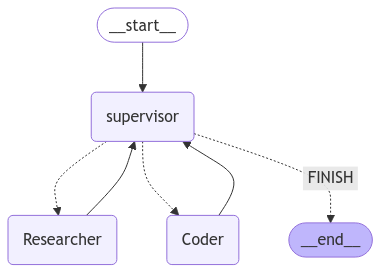

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content='Hello, World!', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'Researcher'}}
----


KeyboardInterrupt: 

In [27]:
graph.invoke(
    {"messages": [HumanMessage(content="Write a brief research report on pikas.")]}
)

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': "Since the research report on pikas has been provided and no further tools are needed, I'll respond directly. The next step would be to decide who should act next in the conversation. Given the context, I would recommend that the Coder should act next."}}

In [28]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief research report on pikas.")]},
    {"recursion_limit": 5},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----


GraphRecursionError: Recursion limit of 5 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.